# Hyperparameter Optimization

In [ ]:
import pandas as pd
import numpy as np

we are working with geological well data from <a href='www.iodp.org'>the ocean drilling program<a>. We will try to predict a lithologic name from downhole measurement data. <a href='https://iodp.tamu.edu/labs/ship/Cdeck_downhole.html'>Downhold measurements</a> are done on drilling vessel to supplement or replace coring information: cores are rarely complete, and sometimes are not collected because coring is an expensive process. Instead, a series of measurement tools is sent down the drilling pipe on a cable (a 'string') and collects measurement values from the rock formation.
<br>
![downhole_lab](https://iodp.tamu.edu/labs/ship/photos/dhml.jpg)
<br>
This particular data comes from IODP Expedition 317, offshore the Canterbury Basin of New Zealand. It consists of downhole measurements of spectral gamma ray and resistivity of the formation. We also have a high-resolution core description datasets that can be used as the label for the downhole log data.

The features in this dataset are as follow:
* **Depth_WMSF**: depth of measurements below seafloor for the logging string
* **HCGR**: Total gamma ray measurement, a bulk measure of radioactivity in the rock
* **HFK**: Gamma-ray value associated with potassium: a good proxy for clay mineral content   
* **HTHO**: Gamma-ray value associated with thorium: another proxy for mineral content
* **HURA**: Gamma-ray value associated with uranium: mostly associated with organic matter or phosphorus
* **HFK**: Gamma-ray value associated with potassium: a good proxy for clay mineral content
* **IDPH**: Deep induction log from the Phasor Dual Induction–Spherically Focused Resistivity Tool
* **IMPH**: Medium induction log from the Phasor Dual Induction–Spherically Focused Resistivity Tool
* **SFLU**: Shallow induction log from the Phasor Dual Induction–Spherically Focused Resistivity Tool

The goal will be to fit the best KNN Classifier. And in particular, how many "neighbors" ("K" in KNN) should consider to best predict lithology from logs?

## Load the data and encode lithology


In [947]:
# Your code below
data = pd.read_csv("litho_log_data.csv")

data


,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU,lithology
0,0.0880,1.9945,0.0354,0.4317,0.0501,1950.0000,1950.0000,0.1589,Interbedded sand and mud
1,0.2404,3.4090,0.0708,0.6778,0.0352,1950.0000,1950.0000,0.1589,Interbedded sand and mud
2,0.3928,5.6734,0.1203,1.1137,0.1518,1950.0000,1950.0000,0.1589,Interbedded sand and mud
3,0.5452,9.4665,0.2242,1.7213,0.0793,1950.0000,1950.0000,0.1589,Interbedded clay and mud
4,0.6976,9.9356,0.2286,1.8462,0.4811,1950.0000,1950.0000,0.1589,Interbedded clay and mud
...,...,...,...,...,...,...,...,...,...
13010,450.1252,41.8986,1.2812,5.9343,2.3948,1.1804,1.0665,0.5415,Marl
13011,45.2024,8.5972,0.1975,1.5990,0.2809,1950.0000,1950.0000,9700.0000,Interbedded clay and mud
13012,41.0448,8.3542,0.1641,1.7166,0.3087,2.5601,1950.0000,1.1648,Interbedded clay and mud
13013,378.3448,53.8906,1.2991,9.6742,2.5816,1.4162,1.2469,0.8535,Sandy Mud


In [ ]:
# EDA (Exploratory Data Analysis)
print("before",data.duplicated().sum())
print(data.isnull().sum().sort_values(ascending=False))
print(data.dtypes)
#data = data.drop_duplicates().reset_index(drop=True)
print("after:",data.duplicated().sum())

before 336
DEPTH_WMSF    0
HCGR          0
HFK           0
HTHO          0
HURA          0
IDPH          0
IMPH          0
SFLU          0
lithology     0
dtype: int64
DEPTH_WMSF    float64
HCGR          float64
HFK           float64
HTHO          float64
HURA          float64
IDPH          float64
IMPH          float64
SFLU          float64
lithology      object
dtype: object
after: 336


In [949]:
X = data.drop(columns=["lithology"],axis=1)
y = data["lithology"]
print(y)
X

0        Interbedded sand and mud 
1        Interbedded sand and mud 
2        Interbedded sand and mud 
3         Interbedded clay and mud
4         Interbedded clay and mud
                   ...            
13010                         Marl
13011     Interbedded clay and mud
13012     Interbedded clay and mud
13013                    Sandy Mud
13014     Interbedded clay and mud
Name: lithology, Length: 13015, dtype: object


,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU
0,0.0880,1.9945,0.0354,0.4317,0.0501,1950.0000,1950.0000,0.1589
1,0.2404,3.4090,0.0708,0.6778,0.0352,1950.0000,1950.0000,0.1589
2,0.3928,5.6734,0.1203,1.1137,0.1518,1950.0000,1950.0000,0.1589
3,0.5452,9.4665,0.2242,1.7213,0.0793,1950.0000,1950.0000,0.1589
4,0.6976,9.9356,0.2286,1.8462,0.4811,1950.0000,1950.0000,0.1589
...,...,...,...,...,...,...,...,...
13010,450.1252,41.8986,1.2812,5.9343,2.3948,1.1804,1.0665,0.5415
13011,45.2024,8.5972,0.1975,1.5990,0.2809,1950.0000,1950.0000,9700.0000
13012,41.0448,8.3542,0.1641,1.7166,0.3087,2.5601,1950.0000,1.1648
13013,378.3448,53.8906,1.2991,9.6742,2.5816,1.4162,1.2469,0.8535


## Scaling

Scaling is always very important for KNN because the algorithm relies on the distance between features



array([[<Axes: title={'center': 'DEPTH_WMSF'}>,
        <Axes: title={'center': 'HCGR'}>,
        <Axes: title={'center': 'HFK'}>],
       [<Axes: title={'center': 'HTHO'}>,
        <Axes: title={'center': 'HURA'}>,
        <Axes: title={'center': 'IDPH'}>],
       [<Axes: title={'center': 'IMPH'}>,
        <Axes: title={'center': 'SFLU'}>, <Axes: >]], dtype=object)

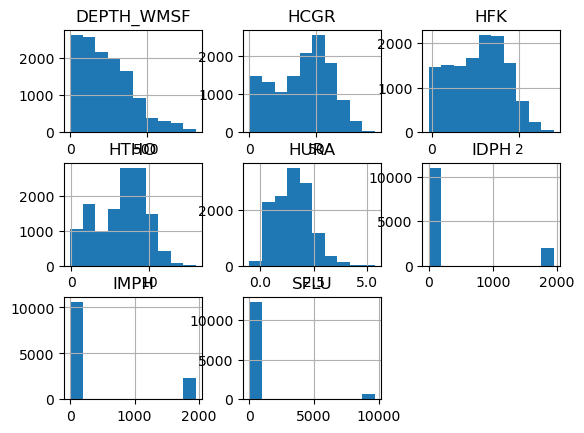

In [950]:
# plot histrogram 
X.hist()

In [ ]:
# Scale data with standard scaler
from sklearn.preprocessing import StandardScaler

scaler_std = StandardScaler()
scaler_std.fit(X[:])
X[:]= scaler_std.transform(X[:])

#scaler_std.fit(X.iloc[:,:])
#X.iloc[:,:] = scaler_std.transform(X.iloc[:,:])
X

,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU
0,-1.408071,-1.839861,-1.701519,-1.915529,-1.788729,2.312489,2.198407,-0.239603
1,-1.407174,-1.771085,-1.643907,-1.837107,-1.806890,2.312489,2.198407,-0.239603
2,-1.406277,-1.660985,-1.563347,-1.698204,-1.664772,2.312489,2.198407,-0.239603
3,-1.405380,-1.476557,-1.394252,-1.504587,-1.753139,2.312489,2.198407,-0.239603
4,-1.404483,-1.453748,-1.387091,-1.464786,-1.263406,2.312489,2.198407,-0.239603
...,...,...,...,...,...,...,...,...
13010,1.240251,0.100358,0.325988,-0.162078,1.069102,-0.436963,-0.482464,-0.239429
13011,-1.142587,-1.518824,-1.437706,-1.543559,-1.507419,2.312489,2.198407,4.178635
13012,-1.167053,-1.530639,-1.492063,-1.506085,-1.473535,-0.435017,2.198407,-0.239145
13013,0.817847,0.683433,0.355120,1.029673,1.296782,-0.436631,-0.482216,-0.239287


In [952]:
# label encoder 
from sklearn.preprocessing import LabelEncoder

class_name = y.unique().tolist()

label_en = LabelEncoder()
label_en.fit(y[:])
y[:] = label_en.transform(y[:])

class_encode = y.unique().tolist()
#print(class_name)
#print(class_encode)
class_all = dict(zip(class_encode,class_name))
print(class_all)
y

{1: 'Interbedded sand and mud ', 0: 'Interbedded clay and mud', 4: 'Sandy Mud', 3: 'Mud', 2: 'Marl'}


C:\Users\Worra\AppData\Local\Temp\ipykernel_18532\1214515154.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[:] = label_en.transform(y[:])


0        1
1        1
2        1
3        0
4        0
        ..
13010    2
13011    0
13012    0
13013    4
13014    0
Name: lithology, Length: 13015, dtype: object

## Train/Test split dataset

In [ ]:

from sklearn.model_selection import train_test_split

y = y.astype(int)
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.3,random_state=0)

# Check train size 
print(y_train.dtypes)
print("X train:,",X_train.shape,"X test:",X_test.shape)
print("y train:",y_train.shape,"y test:",y_test.shape)

X_train

int32
X train:, (3904, 8) X test: (9111, 8)
y train: (3904,) y test: (9111,)


,DEPTH_WMSF,HCGR,HFK,HTHO,HURA,IDPH,IMPH,SFLU
11516,0.603421,0.651814,0.757106,0.502453,1.964345,-0.436882,-0.482240,-0.239184
8126,-0.592949,0.410960,0.475553,0.319096,0.113769,-0.437138,-0.482549,-0.239444
6816,-0.755159,0.995173,1.213613,0.697535,-0.134388,-0.436772,-0.482503,-0.239401
8558,-0.183997,0.590828,0.581013,0.576222,-0.016160,-0.436979,-0.482302,-0.239340
2681,1.161331,0.034815,-0.173809,0.273018,1.164172,-0.436843,-0.482372,-0.239378
...,...,...,...,...,...,...,...,...
4859,-0.228975,0.956641,0.817811,1.072150,0.494537,-0.436823,-0.482405,-0.239366
3264,1.962195,0.420354,0.363746,0.467050,2.198729,-0.436755,-0.482278,-0.239379
9845,-1.002791,-1.412507,-1.393439,-1.370336,-1.240979,-0.372815,-0.312746,-0.238948
10799,-0.102379,0.808620,0.637649,0.969033,0.641530,-0.436911,-0.482208,-0.239201


## 3. Baseline KNN model

Define a simple KNN classifier set with k=100

In [954]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

base_model = KNeighborsClassifier(n_neighbors=100)
#base_model.fit(X_train,y_train)


 5-fold cross validate the simple KNN classifier defined above taking into account only the closest neighbor, and compute its mean cv-score.

In [ ]:

from sklearn.model_selection import cross_validate

cv_base = cross_validate(base_model,X_train,y_train,cv=5,
                    scoring=["accuracy","precision_macro","recall_macro","f1_macro"])



acc_base = cv_base["test_accuracy"].mean()
print(acc_base)
pd.DataFrame(cv_base)


0.7986667323287041


,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,0.003001,0.029053,0.806658,0.796898,0.705154,0.716821
1,0.003001,0.030300,0.796415,0.800078,0.694142,0.699259
2,0.002932,0.028677,0.801536,0.778788,0.697160,0.702717
3,0.003061,0.027210,0.795134,0.790514,0.695005,0.698104
4,0.003371,0.029041,0.793590,0.798564,0.689807,0.688138


## 4. Grid search

Use sklearn `GridSearchCV` to find the best KNN hyperparameter `n_neighbors`.
- Start coarse-grain approach, with `n_neighbors` = [1,10,20,50,100, 200]
- 5-fold cross validate each combination
- Be sure to maximize performance time using `n_jobs`

In [ ]:

from sklearn.model_selection import GridSearchCV
knn_model2 = KNeighborsClassifier()
# Hyperparameter 
grid_hyper = {"n_neighbors":np.arange(1,30,1),
            'p': [1, 2]}

#["accuracy","precision_macro","recall_macro","f1_macro"]
grid_search = GridSearchCV(knn_model2,grid_hyper,cv=5,n_jobs=-1,
    scoring="accuracy",)

grid_search.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'p': [1, 2]},
             scoring='accuracy')

In [957]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.8893440362454446
{'n_neighbors': 5, 'p': 1}
KNeighborsClassifier(p=1)


In [958]:
best_score = grid_search.best_score_
best_k = grid_search.best_params_['n_neighbors']


### Visual check

Perform a grid search manually.
- Loop manually over all values of k from 1 to 50 and store the mean cv-scores of each model in a list.
- Plot the score as a function of k to visualy find the best k

[0.882938704488, 0.8652677369578778, 0.8872943957450999, 0.8798647362027644, 0.8862697396500213, 0.8839636888932663, 0.8847339045930596, 0.8796096391871039, 0.8821717718900818, 0.8773045733609115, 0.8775613119275093, 0.8750001641550937, 0.8755113431169768, 0.8701329656259233, 0.8714146885977871, 0.8665474900686168, 0.8691083095308446, 0.868851570964247, 0.866803243704652, 0.8670609672018124, 0.8639863422962015, 0.8621927837420795, 0.861679963229259, 0.8601431432417348, 0.8573259135230966, 0.8586073081847729, 0.8609117173905906, 0.8588627335106208, 0.8565570110640532, 0.856301257428018, 0.8575813388489445, 0.8557877802948226, 0.854762467579369, 0.8534817295380674, 0.853994550050888, 0.8509209100758396, 0.8498962539807611, 0.8483587773728619, 0.848103352047014, 0.8475898749138185, 0.8478466134804163, 0.8463091368725172, 0.8475905315341935, 0.8429797432614332, 0.8445172198693325, 0.8406750057454282, 0.8409314160018386, 0.8399070882169474, 0.8401631701631702]


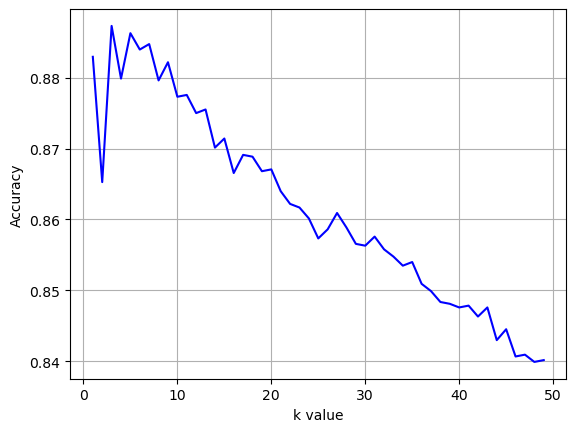

In [960]:
# Your code here
import matplotlib.pyplot as plt 

cv_manual_score = []
k1 = np.arange(1,50,1)
for iter_k in k1:
    knn_manual = KNeighborsClassifier(n_neighbors=iter_k)
    cv_manual = cross_validate(knn_manual,X_train,y_train,cv=5,scoring=["accuracy"])
    cv_manual_score.append(cv_manual["test_accuracy"].mean())
    #print(cv_manual["test_accuracy"].mean())

print(cv_manual_score)

# plot 
plt.figure()
plt.grid()
plt.plot(k1,cv_manual_score,color="b",label="accuray with k")
plt.xlabel("k value"),plt.ylabel("Accuracy")
plt.show()

## 5. Multiple params

KNNRegressor suppports various _distance metrics_ via the hyper-parameter `p`

Use GridSearchCV to search for best `k` and `p` at the same time: Try all combinations for `k` = [1, 3, 5, 7, 9, 20, 50] and `p` = [1, 2, 3]. 

In [ ]:

k = [1, 3, 5, 7, 9, 20, 50]
p = [1, 2, 3]


## 6. Random Search

If a Random Search can find a better combination with the same number of model fits?
Use `RandomizedSearchCV` to
- Randomly sample `k` from a uniform `randint(1,50)` distribition
- Sample `p` from a list [1,2,3]
- Use the correct number of `n_iter` and `cv` to fit the exact same number of models than in your previous GridSearchCV.

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
knn_rn = KNeighborsClassifier()
#k = np.random.randint(1,50,size=50)
k = np.arange(1,100,1)
p = [1,2,3]

#print("k",k)

# Hyperparameter 
grid_rd = {
    'n_neighbors': k,  # Generate values from 1 to 200 with a step of 10
    'weights': ['uniform', 'distance'],
    'p': p,
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30],
    'n_jobs': [-1]
}

search_rd = RandomizedSearchCV(knn_rn,grid_rd,scoring="f1_macro",
                            n_iter=100,
                            cv=10,
                            n_jobs=-1)

search_rd.fit(X_train,y_train)
print(search_rd.best_estimator_)
print(search_rd.best_score_)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='manhattan',
                     n_jobs=-1, n_neighbors=8, weights='distance')
0.8921158532945304


## 7. Generalization

This is final chance to fine-tune the model
- Refine your RandomsearchCV 
- Choose best model hyper-params and instantiate it
- Re-fit it on the __entire__ train set

In [ ]:
print(search_rd.best_params_["n_neighbors"])
final_model = search_rd.best_estimator_

final_model.fit(X_train,y_train) # refit with entire train set


8


KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='manhattan',
                     n_jobs=-1, n_neighbors=8, weights='distance')

Discover model's performance on the **unseen** test set `X_test`. Compute the r2 score for the test set

In [ ]:

from sklearn.metrics import f1_score
y_pred = final_model.predict(X_test) # X_test -> unseen data

f1_test = f1_score(y_test,y_pred,average="weighted")
print(f1_test)

0.8982677590152766
